In [1]:
# Import saved ResNet features
import numpy as np
import pandas as pd


# Load Train Features
train_features_df = pd.read_csv('Custom_CNN_fusion_Stratified/train_features_transformer.csv')
train_labels = train_features_df['Label'].values
groups_train = train_features_df['Image'].str[:].values  # ✅ Extract first 12 chars if patient ID
pseudo_probs_train = train_features_df[
    ['Pseudo_Prob_Class_0', 'Pseudo_Prob_Class_1', 'Pseudo_Prob_Class_2', 
     'Pseudo_Prob_Class_3', 'Pseudo_Prob_Class_4', 'Pseudo_Prob_Class_5']
].values
train_features = train_features_df.drop(columns=[
    'Label', 'Image', 'Pseudo_Prob_Class_0', 'Pseudo_Prob_Class_1', 'Pseudo_Prob_Class_2', 
    'Pseudo_Prob_Class_3', 'Pseudo_Prob_Class_4', 'Pseudo_Prob_Class_5'
]).values


# Load Test Features
test_features_df = pd.read_csv('Custom_CNN_fusion_Stratified/test_features_transformer.csv')
test_labels = test_features_df['Label'].values
groups_test = test_features_df['Image'].str[:].values  # ✅ Extract first 12 chars if patient ID
pseudo_probs_test = test_features_df[
    ['Pseudo_Prob_Class_0', 'Pseudo_Prob_Class_1', 'Pseudo_Prob_Class_2', 
     'Pseudo_Prob_Class_3', 'Pseudo_Prob_Class_4', 'Pseudo_Prob_Class_5']
].values

test_features = test_features_df.drop(columns=[
    'Label', 'Image', 'Pseudo_Prob_Class_0', 'Pseudo_Prob_Class_1', 'Pseudo_Prob_Class_2', 
    'Pseudo_Prob_Class_3', 'Pseudo_Prob_Class_4', 'Pseudo_Prob_Class_5'
]).values

# Print the shape of the feature arrays
print('Train feature shape: ', train_features.shape)
print('Test feature shape: ', test_features.shape)


# Print the pseudo probabilities
print(pseudo_probs_test)


Train feature shape:  (9789, 256)
Test feature shape:  (2611, 256)
[[0.00463025 0.00625174 0.02074885 0.00350867 0.00772718 0.9571333 ]
 [0.00361925 0.00516757 0.0101166  0.00952851 0.00897152 0.96259654]
 [0.00272954 0.00753371 0.01087029 0.00805031 0.00639741 0.96441877]
 ...
 [0.01905265 0.92608374 0.02209971 0.00531116 0.02015011 0.00730256]
 [0.01536749 0.9254944  0.02625894 0.00545662 0.02040335 0.00701927]
 [0.01335277 0.02010148 0.8697333  0.00876164 0.01331125 0.07473968]]


In [ ]:
import torch
import numpy as np
from torch_geometric.data import Data

def graph_data_pseudo_prob_features(features, pseudo_probs, labels, max_neighbors=5):
    """
    - Constructs a graph where nodes are connected based on their pseudo-labels.
    - **No confidence-based filtering (low-confidence nodes are kept).**
    - **Pseudo-probabilities are added as extra node features.**
    
    Args:
        features (np.array): Original node feature matrix (num_nodes, feature_dim).
        pseudo_probs (np.array): Pseudo-label probability distributions (num_nodes, num_classes).
        labels (np.array): Ground truth labels (for evaluation, not used in connectivity).
        max_neighbors (int): Maximum number of neighbors per node.

    Returns:
        PyG Data object with node features including pseudo probabilities.
    """
    num_nodes = features.shape[0]
    feature_tensor = torch.tensor(features, dtype=torch.float)
    pseudo_probs_tensor = torch.tensor(pseudo_probs, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    # ✅ Compute pseudo-labels from pseudo_probs
    pseudo_labels = pseudo_probs.argmax(axis=1)

    # ✅ Step 1: Initialize adjacency matrix
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    # ✅ Step 2: Group nodes by pseudo-labels
    pseudo_label_groups = {c: np.where(pseudo_labels == c)[0] for c in np.unique(pseudo_labels)}

    # ✅ Step 3: Connect nodes within the same pseudo-label group
    for node_idx in range(num_nodes):
        node_label = pseudo_labels[node_idx]
        same_class_nodes = pseudo_label_groups[node_label]

        # Remove self-loop
        same_class_nodes = same_class_nodes[same_class_nodes != node_idx]

        # Limit number of connections
        if len(same_class_nodes) > max_neighbors:
            same_class_nodes = np.random.choice(same_class_nodes, max_neighbors, replace=False)

        # Create connections
        adjacency_matrix[node_idx, same_class_nodes] = 1

    # ✅ Step 4: Convert adjacency matrix to edge index format
    edge_index = np.array(np.nonzero(adjacency_matrix))
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # ✅ Step 5: Concatenate pseudo probabilities as additional node features
    node_features_with_probs = torch.cat([feature_tensor, pseudo_probs_tensor], dim=1)  # (num_nodes, feature_dim + num_classes)

    # ✅ Step 6: Create PyG Data object
    data = Data(x=node_features_with_probs, edge_index=edge_index, y=labels_tensor)
    
    pseudo_labels_tensor = torch.tensor(pseudo_labels, dtype=torch.long)
    data.pseudo_labels = pseudo_labels_tensor
    data.pseudo_probs = pseudo_probs_tensor  # ✅ Each node retains its full probability distribution

    return data

# ✅ Example Usage
train_graph = graph_data_pseudo_prob_features(train_features, pseudo_probs_train, train_labels, max_neighbors=3)
test_graph = graph_data_pseudo_prob_features(test_features, pseudo_probs_test, test_labels, max_neighbors=3)

print(train_graph)
print(f"Train Graph - Nodes: {train_graph.num_nodes}, Edges: {train_graph.num_edges}")
print(f"Test Graph - Nodes: {test_graph.num_nodes}, Edges: {test_graph.num_edges}")

In [ ]:
import torch
import numpy as np
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

def graph_data_separate_confidence(features, pseudo_probs, labels, image_names, max_neighbors=5, confidence_threshold=0.58, filter_test=False):
    """
    - Constructs graph based on high-confidence pseudo-labels.
    - **For test data only**, prints accuracy metrics and visualizes confusion matrices.
    - **Pseudo-labels are now inferred from pseudo_probs (no need to pass pseudo_labels explicitly)**.
    """
    num_nodes = features.shape[0]

    # ✅ Compute pseudo-labels dynamically from pseudo_probs
    pseudo_labels = pseudo_probs.argmax(axis=1)  # Get highest-confidence class for each node
    assigned_pseudo_probs = pseudo_probs[np.arange(num_nodes), pseudo_labels]  # Keep confidence of assigned class

    # ✅ Identify high-confidence & low-confidence nodes
    if filter_test:
        high_confidence_indices = np.where(assigned_pseudo_probs >= confidence_threshold)[0]  # High-confidence nodes
        low_confidence_indices = np.where(assigned_pseudo_probs < confidence_threshold)[0]  # Low-confidence nodes
        discarded_images = [image_names[i] for i in low_confidence_indices]  # Store discarded image names
        kept_images = [image_names[i] for i in high_confidence_indices]  # Store kept image names
    else:
        high_confidence_indices = np.arange(num_nodes)  # Keep all nodes for training
        low_confidence_indices = []
        discarded_images = []  # No images are discarded in training
        kept_images = []

    high_confidence_features = features[high_confidence_indices]
    high_confidence_pseudo_labels = pseudo_labels[high_confidence_indices]
    high_confidence_true_labels = labels[high_confidence_indices]  # True labels for high-confidence nodes

    # ✅ Step 1: Connect high-confidence nodes based on pseudo-labels
    adjacency_matrix = np.zeros((len(high_confidence_indices), len(high_confidence_indices)))

    for idx, i in enumerate(high_confidence_indices):
        same_pseudo_label_indices = high_confidence_indices[high_confidence_pseudo_labels == high_confidence_pseudo_labels[idx]]

        # Exclude the current node
        same_pseudo_label_indices = same_pseudo_label_indices[same_pseudo_label_indices != i]

        # Limit to max_neighbors
        if len(same_pseudo_label_indices) > max_neighbors:
            same_pseudo_label_indices = np.random.choice(same_pseudo_label_indices, max_neighbors, replace=True)

        for j in same_pseudo_label_indices:
            adjacency_matrix[idx, np.where(high_confidence_indices == j)[0][0]] = 1  # Connect similar pseudo-labeled nodes

    # ✅ Step 2: Convert adjacency matrix to edge index
    edge_index = np.array(np.nonzero(adjacency_matrix))
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # ✅ Step 3: Ensure only high-confidence nodes are kept in the graph (for test)
    filtered_feature_tensor = torch.tensor(high_confidence_features, dtype=torch.float)
    filtered_labels_tensor = torch.tensor(high_confidence_true_labels, dtype=torch.long)

    # ✅ Step 4: Compute Accuracy for High-Confidence & Low-Confidence Nodes
    if filter_test:
       

        if len(low_confidence_indices) > 0:
            low_confidence_true_labels = labels[low_confidence_indices]
            low_confidence_pseudo_labels = pseudo_labels[low_confidence_indices]


            # ✅ Confusion Matrix & Visualizations
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))

            # 🔹 **Ground Truth Label Distribution**
            axes[0].hist(low_confidence_true_labels, bins=np.arange(low_confidence_true_labels.min(), low_confidence_true_labels.max() + 2) - 0.5,
                         alpha=0.7, color='blue', edgecolor='black', label='True Labels')
            axes[0].set_xticks(range(low_confidence_true_labels.min(), low_confidence_true_labels.max() + 1))
            axes[0].set_xlabel('Class Labels')
            axes[0].set_ylabel('Count')
            axes[0].set_title('Ground Truth Label Distribution (Low Confidence)')
            axes[0].legend()

            # 🔹 **Pseudo-Label Distribution**
            axes[1].hist(low_confidence_pseudo_labels, bins=np.arange(low_confidence_pseudo_labels.min(), low_confidence_pseudo_labels.max() + 2) - 0.5,
                         alpha=0.7, color='red', edgecolor='black', label='Pseudo Labels')
            axes[1].set_xticks(range(low_confidence_pseudo_labels.min(), low_confidence_pseudo_labels.max() + 1))
            axes[1].set_xlabel('Pseudo Labels')
            axes[1].set_ylabel('Count')
            axes[1].set_title('Pseudo Label Distribution (Low Confidence)')
            axes[1].legend()

            # 🔹 **Confusion Matrix**
            cm = confusion_matrix(low_confidence_true_labels, low_confidence_pseudo_labels)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(low_confidence_true_labels),
                        yticklabels=np.unique(low_confidence_true_labels), ax=axes[2])
            axes[2].set_xlabel("Predicted Pseudo Labels")
            axes[2].set_ylabel("True Labels")
            axes[2].set_title("Confusion Matrix (Low Confidence Nodes)")

            plt.tight_layout()
            plt.show()

    # ✅ Create PyTorch Geometric Graph Data
    data = Data(x=filtered_feature_tensor, edge_index=edge_index, y=filtered_labels_tensor)
    
    pseudo_labels_tensor = torch.tensor(pseudo_labels, dtype=torch.long)
    pseudo_probs_tensor = torch.tensor(assigned_pseudo_probs, dtype=torch.float)  # ✅ Single probability per node
    data.pseudo_labels = pseudo_labels_tensor[high_confidence_indices]
    data.pseudo_probs = pseudo_probs_tensor[high_confidence_indices]
    
    return data, discarded_images, kept_images  # ✅ Return discarded images

# ✅ Example Usage
train_graph, _, _ = graph_data_separate_confidence(train_features, pseudo_probs_train, train_labels, groups_train, max_neighbors=10, filter_test=False)
test_graph, discarded_test_images, kept_images = graph_data_separate_confidence(test_features, pseudo_probs_test, test_labels, groups_test, max_neighbors=10, filter_test=True)

print(train_graph)
print(f"Train Graph - Nodes: {train_graph.num_nodes}, Edges: {train_graph.num_edges}")
print(f"Test Graph - Nodes: {test_graph.num_nodes}, Edges: {test_graph.num_edges}")

# ✅ Print the discarded images for review
print("Discarded Test Images (Low Confidence Nodes):")
print(discarded_test_images)

# ✅ Print the kept test images for review
print("Kept Test Images (High Confidence Nodes):")
print(kept_images)

In [2]:
import torch
import numpy as np
from torch_geometric.data import Data
import random

def generate_confidence_weighted_graph(features, pseudo_labels, pseudo_probs, labels, max_neighbors=3):
    """
    Constructs a graph where:
    - Nodes are connected based on their pseudo-labels.
    - Edge weights are assigned based on confidence scores.
    - No nodes are removed (low-confidence nodes are retained but receive lower edge weights).
    
    Parameters:
    - features: NumPy array of feature vectors.
    - pseudo_labels: NumPy array of pseudo-labels.
    - pseudo_probs: NumPy array of confidence scores.
    - labels: Ground-truth labels (for evaluation purposes).
    - max_neighbors: Maximum number of neighbors for each node.

    Returns:
    - PyTorch Geometric `Data` object containing the graph.
    """
    num_nodes = features.shape[0]
    
    # Convert to PyTorch tensors
    feature_tensor = torch.tensor(features, dtype=torch.float)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    adjacency_matrix = np.zeros((num_nodes, num_nodes))
    edge_weights = np.zeros((num_nodes, num_nodes))  # Edge weight matrix

    for i in range(num_nodes):
        same_pseudo_label_indices = np.where(pseudo_labels == pseudo_labels[i])[0]
        
        # Exclude self-connections
        same_pseudo_label_indices = same_pseudo_label_indices[same_pseudo_label_indices != i]
        
        # Limit to max_neighbors
        if len(same_pseudo_label_indices) > max_neighbors:
            selected_neighbors = np.random.choice(same_pseudo_label_indices, max_neighbors, replace=False)
        else:
            selected_neighbors = same_pseudo_label_indices
        
        # Assign edges with confidence-based weights
        for j in selected_neighbors:
            adjacency_matrix[i, j] = 1
            edge_weights[i, j] = (pseudo_probs[i] + pseudo_probs[j]) / 2  # Confidence-weighted edges
    
    # Add self-loops (confidence weight remains 1.0 for self-loops)
    np.fill_diagonal(adjacency_matrix, 1)
    np.fill_diagonal(edge_weights, 1.0)

    # Convert adjacency matrix to edge index
    edge_index = np.array(np.nonzero(adjacency_matrix))
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # Convert edge weights to PyTorch tensor
    edge_weights = edge_weights[edge_index[0], edge_index[1]]
    edge_weights = torch.tensor(edge_weights, dtype=torch.float)

    # Create PyTorch Geometric Graph Data Object
    data = Data(x=feature_tensor, edge_index=edge_index, y=labels_tensor, edge_attr=edge_weights)
    data.pseudo_probs = torch.tensor(pseudo_probs, dtype=torch.float)

    return data

train_graph = generate_confidence_weighted_graph(train_features, pseudo_labels_train, pseudo_probs_train, train_labels)
test_graph = generate_confidence_weighted_graph(test_features, pseudo_labels_test, pseudo_probs_test, test_labels)

print(train_graph)
print(f"Train Graph - Nodes: {train_graph.num_nodes}, Edges: {train_graph.num_edges}")
print(f"Test Graph - Nodes: {test_graph.num_nodes}, Edges: {test_graph.num_edges}")

/Users/mertdaloglu/anaconda3/envs/gcnn_project/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/mertdaloglu/anaconda3/envs/gcnn_project/lib/python3.9/site-packages/libpyg.so, 0x0006): Library not loaded: /Library/Frameworks/Python.framework/Versions/3.9/Python
  Referenced from: <2695749E-A917-3F14-B0DA-2A4914D2853D> /Users/mertdaloglu/anaconda3/envs/gcnn_project/lib/python3.9/site-packages/libpyg.so
  Reason: tried: '/Library/Frameworks/Python.framework/Versions/3.9/Python' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.9/Python' (no such file), '/Library/Frameworks/Python.framework/Versions/3.9/Python' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64'))
  warnings.warn(f"An issue occurred while importi

Data(x=[9789, 256], edge_index=[2, 39156], edge_attr=[39156], y=[9789], pseudo_probs=[9789])
Train Graph - Nodes: 9789, Edges: 39156
Test Graph - Nodes: 2611, Edges: 10444


/var/folders/gk/dsypcq4n5hg6hh5qdss0ly540000gn/T/ipykernel_1347/2852487311.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('jet', len(unique_labels))  # Generate color map


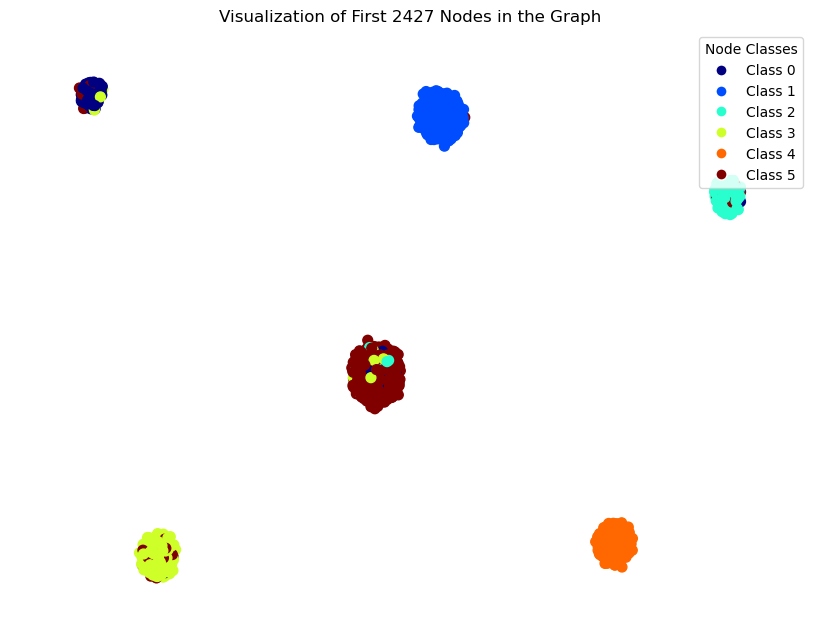

In [13]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import numpy as np

def visualize_subgraph(data):
    """
    Convert a PyTorch Geometric graph into a NetworkX graph and visualize a small subgraph.

    Args:
        data (torch_geometric.data.Data): Graph data.
       
    """
    
    num_nodes = data.num_nodes
    
    # Convert PyG graph to NetworkX format
    G = to_networkx(data, to_undirected=True)

    # Extract a subset of nodes
    sub_nodes = list(G.nodes)[:num_nodes]  # Select first `num_nodes`
    subgraph = G.subgraph(sub_nodes)

    # Assign colors based on class labels
    node_labels = np.array([data.y[i].item() for i in sub_nodes])  # Get labels of selected nodes
    unique_labels = np.unique(node_labels)  # Unique class labels

    # Create a color map for unique class labels
    color_map = plt.cm.get_cmap('jet', len(unique_labels))  # Generate color map
    label_color_mapping = {label: color_map(i / len(unique_labels)) for i, label in enumerate(unique_labels)}  # Map labels to colors
    node_colors = [label_color_mapping[label] for label in node_labels]  # Assign colors

    # Plot the graph
    plt.figure(figsize=(8, 6))
    nx.draw(subgraph, with_labels=False, node_size=50, node_color=node_colors)

    plt.title(f"Visualization of First {num_nodes} Nodes in the Graph")

    # Create a legend for the node colors
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color_mapping[label], markersize=8, label=f"Class {label}") 
                      for label in unique_labels]
    plt.legend(handles=legend_patches, title="Node Classes", loc="upper right")

    plt.show()

# Call the function to visualize the graph (first 55 nodes)
visualize_subgraph(test_graph)

In [23]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils import GCNNClassifier, GCNN_Dot_Product, GCNN_Concat_Attention, GCNN_Prod_Res, GATClassifier, GraphSAGEClassifier, GNClassifier


In [24]:
# Choose the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Choose and Define the model
in_channels = train_graph.x.shape[1]  # (feature vector size)
hidden_channels = 256
num_classes = 6
model = GNClassifier(in_channels, hidden_channels, num_classes).to(device)

In [25]:
import torch.nn.functional as F
def confidence_weighted_loss(preds, true_labels, confidence_scores, beta=5):
    """
    Computes confidence-weighted cross-entropy loss using a logarithmic scaling function.

    - beta: Scaling factor. Higher values increase the gap between high- and low-confidence nodes.
    """
    ce_loss = F.cross_entropy(preds, true_labels, reduction='none')

    # Log-transformed confidence scaling
    scaled_confidence = torch.log1p(beta * confidence_scores.max())  # log(1 + beta * c)

    weighted_loss = (scaled_confidence * ce_loss).mean()

    return weighted_loss

In [26]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight


# Get unique classes
unique_classes = np.unique(train_labels)
# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=unique_classes, y=train_labels)
# Convert to PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Early stopping parameters (based on validation accuracy)
best_val_acc = 0.0
patience = 150
counter = 0

# Lists to store losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 150  # Set high, but will stop early if necessary


# Define loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
# ADD LEARNING RATE SCHEDULER
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=num_epochs//5, gamma=0.5)  # Reduce LR every 50 epochs



for epoch in tqdm(range(num_epochs), desc="Training", total=num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(train_graph.x.to(device), train_graph.edge_index.to(device))
    
    
    #train_loss = criterion(out, train_graph.y.to(device))
    #train_loss = confidence_weighted_loss(out, train_graph.y.to(device), train_graph.pseudo_probs.to(device))
    train_loss = model.loss(train_graph.to(device), augmentation=False)
    
    train_loss.backward()
    optimizer.step()
    scheduler.step() 
    
    # Compute training accuracy
    pred_train = out.argmax(dim=1)
    train_acc = (pred_train == train_graph.y.to(device)).sum().item() / train_graph.y.size(0)

    # Validation step
    model.eval()
    with torch.no_grad():
        val_out = model(test_graph.x.to(device), test_graph.edge_index.to(device))

        #val_loss = criterion(val_out, test_graph.y.to(device))
        #val_loss = confidence_weighted_loss(val_out, test_graph.y.to(device), test_graph.pseudo_probs.to(device))
        val_loss = model.loss(test_graph.to(device), augmentation=False)
         
        # Convert logits to probabilities
        val_probs = torch.softmax(val_out, dim=1)  
        pred_val = val_probs.argmax(dim=1)  # Get class predictions
        # Compute validation accuracy
        val_acc = (pred_val == test_graph.y.to(device)).sum().item() / test_graph.y.size(0)

    # Store losses
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())


    print(f"Epoch {epoch+1}, Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Train Acc: {train_acc:.2f}, Val Acc: {val_acc:.4f}")

    # Early Stopping Logic (Based on Validation Accuracy)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), "best_gcnn.pth")  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print(f"Stopping early at epoch {epoch+1}. Best Val Acc: {best_val_acc:.4f}")
            break

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

Training:   0%|          | 0/150 [00:00<?, ?it/s]

Training:   1%|          | 1/150 [00:20<52:01, 20.95s/it]

Epoch 1, Train Loss: 144.9695, Val Loss: 21.9092, Train Acc: 0.33, Val Acc: 0.6841


Training:   1%|▏         | 2/150 [00:50<1:04:13, 26.04s/it]

Epoch 2, Train Loss: 83.9766, Val Loss: 16.9624, Train Acc: 0.69, Val Acc: 0.7372


Training:   2%|▏         | 3/150 [01:21<1:09:30, 28.37s/it]

Epoch 3, Train Loss: 64.0929, Val Loss: 13.9600, Train Acc: 0.75, Val Acc: 0.8105


Training:   3%|▎         | 4/150 [01:48<1:07:45, 27.84s/it]

Epoch 4, Train Loss: 52.4628, Val Loss: 11.9007, Train Acc: 0.82, Val Acc: 0.8295


Training:   3%|▎         | 5/150 [02:13<1:04:50, 26.83s/it]

Epoch 5, Train Loss: 44.4664, Val Loss: 10.0644, Train Acc: 0.84, Val Acc: 0.8365


Training:   4%|▍         | 6/150 [02:38<1:02:41, 26.12s/it]

Epoch 6, Train Loss: 37.5160, Val Loss: 8.6154, Train Acc: 0.84, Val Acc: 0.8381


Training:   5%|▍         | 7/150 [03:07<1:04:43, 27.15s/it]

Epoch 7, Train Loss: 32.0764, Val Loss: 7.4427, Train Acc: 0.85, Val Acc: 0.8390


Training:   5%|▌         | 8/150 [03:27<58:33, 24.74s/it]  

Epoch 8, Train Loss: 27.6808, Val Loss: 6.7003, Train Acc: 0.85, Val Acc: 0.8410


Training:   6%|▌         | 9/150 [03:45<53:01, 22.56s/it]

Epoch 9, Train Loss: 24.9323, Val Loss: 5.9819, Train Acc: 0.85, Val Acc: 0.8447


Training:   7%|▋         | 10/150 [04:03<49:32, 21.23s/it]

Epoch 10, Train Loss: 22.3058, Val Loss: 5.3642, Train Acc: 0.85, Val Acc: 0.8464


Training:   7%|▋         | 11/150 [04:26<50:20, 21.73s/it]

Epoch 11, Train Loss: 20.0358, Val Loss: 4.8128, Train Acc: 0.86, Val Acc: 0.8501


Training:   8%|▊         | 12/150 [04:50<51:43, 22.49s/it]

Epoch 12, Train Loss: 17.9301, Val Loss: 4.4063, Train Acc: 0.86, Val Acc: 0.8587


Training:   9%|▊         | 13/150 [05:08<48:31, 21.25s/it]

Epoch 13, Train Loss: 16.4342, Val Loss: 3.9858, Train Acc: 0.87, Val Acc: 0.8670


Training:   9%|▉         | 14/150 [05:27<46:32, 20.53s/it]

Epoch 14, Train Loss: 14.9243, Val Loss: 3.6256, Train Acc: 0.89, Val Acc: 0.8764


Training:  10%|█         | 15/150 [05:47<45:20, 20.15s/it]

Epoch 15, Train Loss: 13.5042, Val Loss: 3.3433, Train Acc: 0.90, Val Acc: 0.8880


Training:  11%|█         | 16/150 [06:16<50:58, 22.82s/it]

Epoch 16, Train Loss: 12.3838, Val Loss: 3.0568, Train Acc: 0.92, Val Acc: 0.8954


Training:  11%|█▏        | 17/150 [06:41<52:02, 23.48s/it]

Epoch 17, Train Loss: 11.2841, Val Loss: 2.9083, Train Acc: 0.93, Val Acc: 0.9057


Training:  12%|█▏        | 18/150 [07:09<54:41, 24.86s/it]

Epoch 18, Train Loss: 10.5296, Val Loss: 2.7975, Train Acc: 0.94, Val Acc: 0.9114


Training:  13%|█▎        | 19/150 [07:29<51:24, 23.55s/it]

Epoch 19, Train Loss: 10.2284, Val Loss: 2.7058, Train Acc: 0.95, Val Acc: 0.9193


Training:  13%|█▎        | 20/150 [07:52<50:28, 23.29s/it]

Epoch 20, Train Loss: 9.6349, Val Loss: 2.4098, Train Acc: 0.96, Val Acc: 0.9250


Training:  14%|█▍        | 21/150 [08:23<54:53, 25.53s/it]

Epoch 21, Train Loss: 8.5214, Val Loss: 2.2264, Train Acc: 0.96, Val Acc: 0.9255


Training:  15%|█▍        | 22/150 [08:44<51:51, 24.31s/it]

Epoch 22, Train Loss: 8.0416, Val Loss: 2.2611, Train Acc: 0.97, Val Acc: 0.9226


Training:  15%|█▌        | 23/150 [09:08<51:08, 24.16s/it]

Epoch 23, Train Loss: 7.9366, Val Loss: 1.9562, Train Acc: 0.97, Val Acc: 0.9222


Training:  16%|█▌        | 24/150 [09:33<51:36, 24.57s/it]

Epoch 24, Train Loss: 6.8742, Val Loss: 2.0096, Train Acc: 0.97, Val Acc: 0.9209


Training:  17%|█▋        | 25/150 [09:58<51:00, 24.48s/it]

Epoch 25, Train Loss: 7.0822, Val Loss: 1.9662, Train Acc: 0.97, Val Acc: 0.9213


Training:  17%|█▋        | 26/150 [10:21<49:38, 24.02s/it]

Epoch 26, Train Loss: 6.5406, Val Loss: 1.7251, Train Acc: 0.97, Val Acc: 0.9205


Training:  18%|█▊        | 27/150 [10:43<48:20, 23.58s/it]

Epoch 27, Train Loss: 5.7142, Val Loss: 1.8051, Train Acc: 0.97, Val Acc: 0.9201


Training:  19%|█▊        | 28/150 [11:11<50:27, 24.81s/it]

Epoch 28, Train Loss: 6.0561, Val Loss: 1.6114, Train Acc: 0.97, Val Acc: 0.9197


Training:  19%|█▉        | 29/150 [11:39<52:09, 25.86s/it]

Epoch 29, Train Loss: 5.1990, Val Loss: 1.5676, Train Acc: 0.97, Val Acc: 0.9201


Training:  20%|██        | 30/150 [11:59<47:58, 23.99s/it]

Epoch 30, Train Loss: 5.0407, Val Loss: 1.5865, Train Acc: 0.97, Val Acc: 0.9197


Training:  21%|██        | 31/150 [12:16<43:32, 21.95s/it]

Epoch 31, Train Loss: 5.1980, Val Loss: 1.4110, Train Acc: 0.97, Val Acc: 0.9193


Training:  21%|██▏       | 32/150 [12:33<40:09, 20.42s/it]

Epoch 32, Train Loss: 4.4772, Val Loss: 1.4576, Train Acc: 0.97, Val Acc: 0.9197


Training:  22%|██▏       | 33/150 [12:52<39:01, 20.01s/it]

Epoch 33, Train Loss: 4.5156, Val Loss: 1.4169, Train Acc: 0.97, Val Acc: 0.9197


Training:  23%|██▎       | 34/150 [13:11<38:14, 19.78s/it]

Epoch 34, Train Loss: 4.3409, Val Loss: 1.2902, Train Acc: 0.97, Val Acc: 0.9197


Training:  23%|██▎       | 35/150 [13:28<36:30, 19.04s/it]

Epoch 35, Train Loss: 3.9483, Val Loss: 1.3185, Train Acc: 0.97, Val Acc: 0.9201


Training:  24%|██▍       | 36/150 [13:47<35:51, 18.87s/it]

Epoch 36, Train Loss: 4.0846, Val Loss: 1.2382, Train Acc: 0.97, Val Acc: 0.9197


Training:  25%|██▍       | 37/150 [14:11<38:28, 20.43s/it]

Epoch 37, Train Loss: 3.7295, Val Loss: 1.2931, Train Acc: 0.97, Val Acc: 0.9197


Training:  25%|██▌       | 38/150 [14:30<37:18, 19.99s/it]

Epoch 38, Train Loss: 3.8540, Val Loss: 1.2244, Train Acc: 0.97, Val Acc: 0.9205


Training:  26%|██▌       | 39/150 [14:51<37:46, 20.42s/it]

Epoch 39, Train Loss: 3.6611, Val Loss: 1.1742, Train Acc: 0.97, Val Acc: 0.9205


Training:  27%|██▋       | 40/150 [15:09<36:07, 19.71s/it]

Epoch 40, Train Loss: 3.6101, Val Loss: 1.1540, Train Acc: 0.97, Val Acc: 0.9209


Training:  27%|██▋       | 40/150 [15:16<42:00, 22.92s/it]


KeyboardInterrupt: 

In [148]:
# Load the best model best_gcnn.pth and evaluate on the test set

# Load the best model
model.load_state_dict(torch.load("best_gcnn.pth"))
model.eval()

# Test set evaluation
with torch.no_grad():
    test_out = model(test_graph.x.to(device), test_graph.edge_index.to(device))
    test_probs = torch.softmax(test_out, dim=1)  # Convert logits to probabilities
    pred_test = test_probs.argmax(dim=1)  # Get class predictions
    test_acc = (pred_test == test_graph.y.to(device)).sum().item() / test_graph.y.size(0)

    print(f"Test Accuracy: {test_acc:.4f}")
    
    

/var/folders/gk/dsypcq4n5hg6hh5qdss0ly540000gn/T/ipykernel_6356/3483976095.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_gcnn.pt

Test Accuracy: 0.9341
